In [1]:
%%rqalpha -h
""

UsageError: Cell magic `%%rqalpha` not found.


In [2]:
%load_ext rqalpha

In [3]:
## %%rqalpha -s 20100101 -e 20180716 -p -bm 000001.XSHG --account stock 100000

In [4]:
#海龟交易系统

In [5]:
%%rqalpha -s 20180101 -e 20181101 -p -bm 000001.XSHG --account stock 100000

public class TurtleOriginalStrategy implements IHStrategy {
  Core talibCore;

//定义全局变量
  static int tradedayNum = 0;
  static double unit = 0;
  static double atr = 0;
  static String tradingSignal = "start";
  static String preTradingSignal = "";
  static int units_hold_max = 4;
  static int units_hold = 0;
  static double quantity = 0;
  static double max_add = 0;
  static double firstOpenPrice = 0;
  
  //计算最大最小值
  public double[] getExtremem(double[] arrayHighPriceResult, double[] arrayLowPriceResult) {
      DescriptiveStatistics forMax = new DescriptiveStatistics();
      for (int i = 0; i < arrayHighPriceResult.length-1; i++) {
          forMax.addValue(arrayHighPriceResult[i]);
      }
      double maxResult = forMax.getMax();
      
      DescriptiveStatistics forMin = new DescriptiveStatistics();
      for (int i = 0; i < arrayLowPriceResult.length-1; i++) {
          forMin.addValue(arrayLowPriceResult[i]);
      }
      double minResult = forMin.getMin();
      
      double[] forExtremum = new double[2];
      forExtremum[0] = maxResult;
      forExtremum[1] = minResult;
      return forExtremum;
  }
  //计算Atr以及单位
  public double[] getAtrAndUnit(double[] atrArrayResult, MInteger atrLengthResult, double portfolioValueResult) {
      double atr = atrArrayResult[atrLengthResult.value-1];
      double unit = Math.floor(portfolioValueResult * .01 / atr);
      double[] atrAndUnit = new double[2];
      atrAndUnit[0] = atr;
      atrAndUnit[1] = unit;
      return atrAndUnit;
  }
  //计算止损线价位
  public double getStopPrice(double firstOpenPriceResult, int units_hold_result, double atrResult) {
      double stopPrice =  firstOpenPriceResult - 2*atrResult + (units_hold_result-1)*0.5*atrResult;
      return stopPrice;
  }
  
  
 
  @Override
  public void init(IHInformer informer, IHInitializers initializers) {
    
    talibCore = new Core();
    
    
    int openObserveTime = 55;
    int closeObserveTime = 20;
    int atrTime = 20;
    MInteger atrBegin = new MInteger();
    MInteger atrLength = new MInteger();

    
    String stockId = "CSI300.INDX";
    initializers.instruments((universe) -> universe.add(stockId));
    
    
    initializers.events().statistics((stats, info, trans) -> {

        //获取组合总价值，包含市场价值与剩余资金
        double portfolioValue = info.portfolio().getPortfolioValue();
        
        
        double[] highPrice = stats.get(stockId).history(openObserveTime+1, HPeriod.Day).getHighPrice();
        double[] lowPriceForAtr = stats.get(stockId).history(openObserveTime+1, HPeriod.Day).getLowPrice();
        double[] lowPriceForExtremem = stats.get(stockId).history(closeObserveTime+1, HPeriod.Day).getLowPrice();
        double[] closePrice = stats.get(stockId).history(openObserveTime+2, HPeriod.Day).getClosingPrice();
        
        double closePriceForAtr[] = new double[closePrice.length-1];
        for (int i = 0; i < closePrice.length-1; i++) {
            closePriceForAtr[i] = closePrice[i];
        }
        
       
        double[] atrArray = new double[openObserveTime];
        //Talib计算N即ATR
        RetCode retCode = talibCore.atr(0, openObserveTime-1, highPrice, lowPriceForAtr, closePriceForAtr, atrTime, atrBegin, atrLength, atrArray);
        
        
        double max = getExtremem(highPrice, lowPriceForExtremem)[0];
        double min = getExtremem(highPrice, lowPriceForExtremem)[1];
        
        
        double atr = atrArray[atrLength.value-1];
        
        if (tradingSignal != "start") {
            if (units_hold != 0) {
            max_add += 0.5 * getAtrAndUnit(atrArray, atrLength, portfolioValue)[0];
            }
        } else {
            max_add = stats.get(stockId).getLastPrice();
        }
        
        informer.info(units_hold);
        
        double curPosition = info.position(stockId).getNonClosedTradeQuantity();
        double availableCash = info.portfolio().getAvailableCash();
        double marketValue = info.portfolio().getMarketValue();
        
        
        if (curPosition > 0 & stats.get(stockId).getLastPrice() < getStopPrice(firstOpenPrice, units_hold, atr)) {
            tradingSignal = "stop";
        } else {
            if (curPosition > 0 & stats.get(stockId).getLastPrice() < min) {
                tradingSignal = "exit";
            } else {
                if (stats.get(stockId).getLastPrice() > max_add & units_hold != 0 & units_hold < units_hold_max & availableCash > stats.get(stockId).getLastPrice()*unit) {
                    tradingSignal = "entry_add";
                } else {
                    if (stats.get(stockId).getLastPrice() > max & units_hold == 0) {
                        max_add = stats.get(stockId).getLastPrice();
                        tradingSignal = "entry";
                    }
                }
            }
        }
        
        //informer.info(tradingSignal);
        
        atr = getAtrAndUnit(atrArray, atrLength, portfolioValue)[0];
        if (tradedayNum % 5 == 0) {
            unit = getAtrAndUnit(atrArray, atrLength, portfolioValue)[1];
        }
        tradedayNum += 1;
        
        double quantity = unit;
        
        
        if (tradingSignal != preTradingSignal | (units_hold < units_hold_max & units_hold > 1) | tradingSignal == "stop") {
            
            
            if (tradingSignal == "entry") {
                quantity = unit;
                if (availableCash > stats.get(stockId).getLastPrice()*quantity) {
                    trans.buy(stockId).shares(quantity).commit();
                    firstOpenPrice = stats.get(stockId).getLastPrice();
                    units_hold = 1;
                    informer.info("entrybuy" + quantity);
                }
            }
            if (tradingSignal == "entry_add") {
                quantity = unit;
                trans.buy(stockId).shares(quantity).commit();
                units_hold += 1;
                informer.info("entry_addbuy" + quantity);
            }
            
            
            if (tradingSignal == "stop") {
                if (/*curPosition marketValue*/ units_hold > 0) {
                    trans.sell(stockId).shares(quantity).commit();
                    units_hold -= 1;
                    informer.info("stop" + quantity);
                }
            }
            if (tradingSignal == "exit") {
                if (curPosition > 0) {
                    trans.sell(stockId).shares(curPosition).commit();
                    units_hold = 0;
                    informer.info("exitsell" + curPosition);
                }
            }
            
        }
        
        preTradingSignal = tradingSignal;
    
    });
      
  }
}

[2018-11-22 22:34:02.302553] ERROR: system_log: in parse_user_config, exception: invalid syntax (strategy.py, line 2)


AttributeError: module 'better_exceptions' has no attribute 'format_traceback'

In [4]:
#单股票 MACD 算法示例

2013-01-14 WARN 订单被拒单: [000001.XSHE] 已涨停。
2013-07-11 WARN 订单被拒单: [000001.XSHE] 已涨停。
[2018-11-22 22:34:37.489707] WARN: system_log: Missing Chinese fonts. Fallback to English.


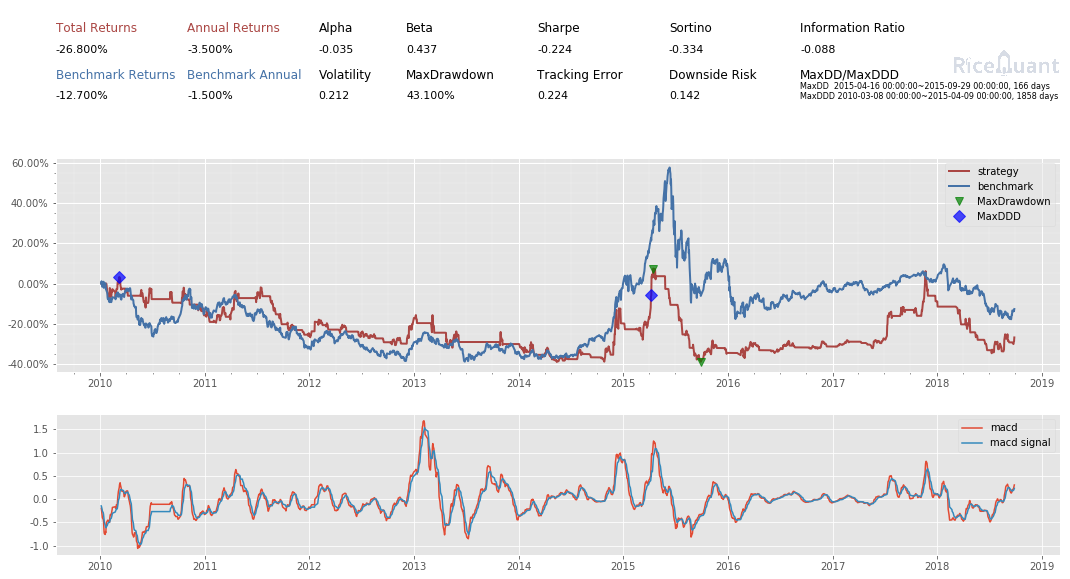

In [6]:
%%rqalpha -s 20100101 -e 20181001 -p -bm 000001.XSHG --account stock 100000

import talib


# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):
    context.s1 = "000001.XSHE"

    # 使用MACD需要设置长短均线和macd平均线的参数
    context.SHORTPERIOD = 12
    context.LONGPERIOD = 26
    context.SMOOTHPERIOD = 9
    context.OBSERVATION = 100


# 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
def handle_bar(context, bar_dict):
    # 开始编写你的主要的算法逻辑

    # bar_dict[order_book_id] 可以拿到某个证券的bar信息
    # context.portfolio 可以拿到现在的投资组合状态信息

    # 使用order_shares(id_or_ins, amount)方法进行落单

    # TODO: 开始编写你的算法吧！

    # 读取历史数据，使用sma方式计算均线准确度和数据长度无关，但是在使用ema方式计算均线时建议将历史数据窗口适当放大，结果会更加准确
    prices = history_bars(context.s1, context.OBSERVATION,'1d','close')

    # 用Talib计算MACD取值，得到三个时间序列数组，分别为macd, signal 和 hist
    macd, signal, hist = talib.MACD(prices, context.SHORTPERIOD,
                                    context.LONGPERIOD, context.SMOOTHPERIOD)

    plot("macd", macd[-1])
    plot("macd signal", signal[-1])

    # macd 是长短均线的差值，signal是macd的均线，使用macd策略有几种不同的方法，我们这里采用macd线突破signal线的判断方法

    # 如果macd从上往下跌破macd_signal

    if macd[-1] - signal[-1] < 0 and macd[-2] - signal[-2] > 0:
        # 计算现在portfolio中股票的仓位
        curPosition = context.portfolio.positions[context.s1].quantity
        #进行清仓
        if curPosition > 0:
            order_target_value(context.s1, 0)

    # 如果短均线从下往上突破长均线，为入场信号
    if macd[-1] - signal[-1] > 0 and macd[-2] - signal[-2] < 0:
        # 满仓入股
        order_target_percent(context.s1, 1)

In [ ]:
#Golden Cross算法示例

[2018-11-22 22:34:56.841737] WARN: system_log: Missing Chinese fonts. Fallback to English.


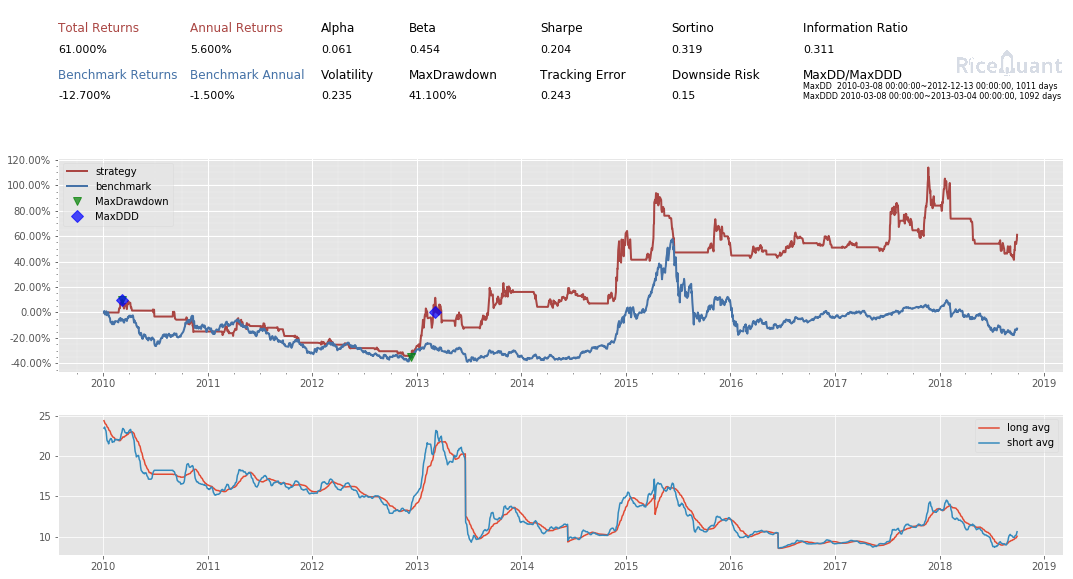

In [7]:
%%rqalpha -s 20100101 -e 20181001 -p -bm 000001.XSHG --account stock 100000


import talib


# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):
    context.s1 = "000001.XSHE"

    # 设置这个策略当中会用到的参数，在策略中可以随时调用，这个策略使用长短均线，我们在这里设定长线和短线的区间，在调试寻找最佳区间的时候只需要在这里进行数值改动
    context.SHORTPERIOD =7
    context.LONGPERIOD = 30


# 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
def handle_bar(context, bar_dict):
    # 开始编写你的主要的算法逻辑

    # bar_dict[order_book_id] 可以拿到某个证券的bar信息
    # context.portfolio 可以拿到现在的投资组合状态信息

    # 使用order_shares(id_or_ins, amount)方法进行落单

    # TODO: 开始编写你的算法吧！

    # 因为策略需要用到均线，所以需要读取历史数据
    prices = history_bars(context.s1, context.LONGPERIOD+1, '1d', 'close')

    # 使用talib计算长短两根均线，均线以array的格式表达
    short_avg = talib.SMA(prices, context.SHORTPERIOD)
    long_avg = talib.SMA(prices, context.LONGPERIOD)

    plot("short avg", short_avg[-1])
    plot("long avg", long_avg[-1])

    # 计算现在portfolio中股票的仓位
    cur_position = context.portfolio.positions[context.s1].quantity
    # 计算现在portfolio中的现金可以购买多少股票
    shares = context.portfolio.cash/bar_dict[context.s1].close

    # 如果短均线从上往下跌破长均线，也就是在目前的bar短线平均值低于长线平均值，而上一个bar的短线平均值高于长线平均值
    if short_avg[-1] - long_avg[-1] < 0 and short_avg[-2] - long_avg[-2] > 0 and cur_position > 0:
        # 进行清仓
        order_target_value(context.s1, 0)

    # 如果短均线从下往上突破长均线，为入场信号
    if short_avg[-1] - long_avg[-1] > 0 and short_avg[-2] - long_avg[-2] < 0:
        # 满仓入股
        order_shares(context.s1, shares)

In [ ]:
多股票RSI算法示例

2018-01-29 INFO target available cash caled: 30000.0
2018-01-30 INFO target available cash caled: 21136.31472
2018-01-31 INFO target available cash caled: 14870.60616
2018-02-01 INFO target available cash caled: 10517.12616
2018-02-02 INFO target available cash caled: 7478.09688
2018-02-05 INFO target available cash caled: 5352.39768
2018-02-06 INFO target available cash caled: 3806.49768
2018-02-07 INFO target available cash caled: 2748.99768
2018-02-07 INFO target available cash caled: 1972.29768
2018-02-08 INFO target available cash caled: 1455.99768
2018-02-08 INFO target available cash caled: 1078.29768
2018-02-09 INFO target available cash caled: 818.19768
2018-02-09 INFO target available cash caled: 818.19768
2018-02-12 INFO target available cash caled: 690.39768
2018-02-12 INFO target available cash caled: 690.39768
2018-02-13 INFO target available cash caled: 560.4976800000001
2018-02-13 INFO target available cash caled: 560.4976800000001
2018-02-14 INFO target available cash 

2018-10-19 INFO target available cash caled: 843.6088200000041
2018-10-22 INFO target available cash caled: 636.9088200000042
2018-10-23 INFO target available cash caled: 492.00882000000416
2018-10-24 INFO target available cash caled: 348.9088200000042
2018-10-25 INFO target available cash caled: 275.4088200000042
[2018-11-22 22:35:47.780360] WARN: system_log: Missing Chinese fonts. Fallback to English.


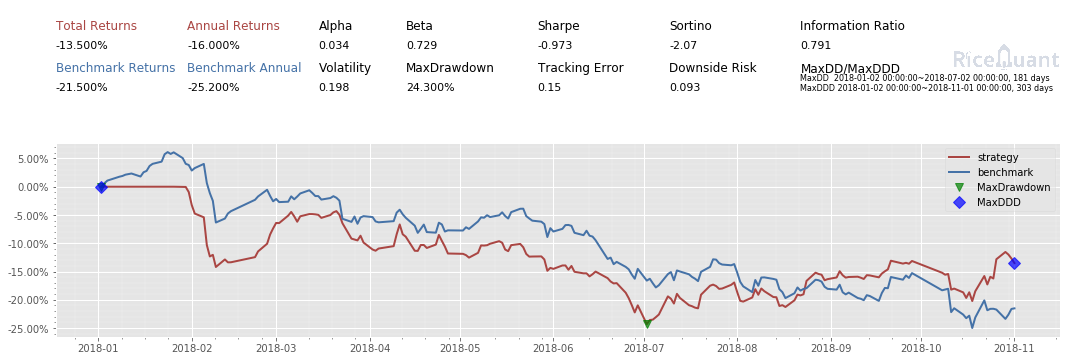

In [9]:
%%rqalpha -s 20180101 -e 20181101 -p -bm 000001.XSHG --account stock 100000

import talib


# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):

    # 选择我们感兴趣的股票
    context.s1 = "000001.XSHE"
    context.s2 = "601988.XSHG"
    context.s3 = "000068.XSHE"
    context.stocks = [context.s1, context.s2, context.s3]

    context.TIME_PERIOD = 14
    context.HIGH_RSI = 85
    context.LOW_RSI = 30
    context.ORDER_PERCENT = 0.3


# 你选择的证券的数据更新将会触发此段逻辑，例如日或分钟历史数据切片或者是实时数据切片更新
def handle_bar(context, bar_dict):
    # 开始编写你的主要的算法逻辑

    # bar_dict[order_book_id] 可以拿到某个证券的bar信息
    # context.portfolio 可以拿到现在的投资组合状态信息

    # 使用order_shares(id_or_ins, amount)方法进行落单

    # TODO: 开始编写你的算法吧！

    # 对我们选中的股票集合进行loop，运算每一只股票的RSI数值
    for stock in context.stocks:
        # 读取历史数据
        prices = history_bars(stock, context.TIME_PERIOD+1, '1d', 'close')

        # 用Talib计算RSI值
        rsi_data = talib.RSI(prices, timeperiod=context.TIME_PERIOD)[-1]

        cur_position = context.portfolio.positions[stock].quantity
        # 用剩余现金的30%来购买新的股票
        target_available_cash = context.portfolio.cash * context.ORDER_PERCENT

        # 当RSI大于设置的上限阀值，清仓该股票
        if rsi_data > context.HIGH_RSI and cur_position > 0:
            order_target_value(stock, 0)

        # 当RSI小于设置的下限阀值，用剩余cash的一定比例补仓该股
        if rsi_data < context.LOW_RSI:
            logger.info("target available cash caled: " + str(target_available_cash))
            # 如果剩余的现金不够一手 - 100shares，那么会被ricequant 的order management system reject掉
            order_value(stock, target_available_cash)

In [ ]:
#股指期货MACD日回测

In [10]:
%%rqalpha -s 20180101 -e 20181101 -p -bm 000001.XSHG --account stock 100000
# 可以自己import我们平台支持的第三方python模块，比如pandas、numpy等
import talib


# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递
def init(context):
    # context内引入全局变量s1，存储目标合约信息
    context.s1 = 'IF1606'

    # 使用MACD需要设置长短均线和macd平均线的参数
    context.SHORTPERIOD = 12
    context.LONGPERIOD = 26
    context.SMOOTHPERIOD = 9
    context.OBSERVATION = 50

    #初始化时订阅合约行情。订阅之后的合约行情会在handle_bar中进行更新
    subscribe(context.s1)


# 你选择的期货数据更新将会触发此段逻辑，例如日线或分钟线更新
def handle_bar(context, bar_dict):
    # 开始编写你的主要的算法逻辑
    # 获取历史收盘价序列，history_bars函数直接返回ndarray，方便之后的有关指标计算
    prices = history_bars(context.s1, context.OBSERVATION, '1d', 'close')

    # 用Talib计算MACD取值，得到三个时间序列数组，分别为macd,signal 和 hist
    macd, signal, hist = talib.MACD(prices, context.SHORTPERIOD,
                                    context.LONGPERIOD, context.SMOOTHPERIOD)

    # macd 是长短均线的差值，signal是macd的均线，如果短均线从下往上突破长均线，为入场信号，进行买入开仓操作
    if macd[-1] - signal[-1] > 0 and macd[-2] - signal[-2] < 0:
        sell_qty = context.portfolio.positions[context.s1].sell_quantity
        # 先判断当前卖方仓位，如果有，则进行平仓操作
        if sell_qty > 0:
            buy_close(context.s1, 1)
        # 买入开仓
        buy_open(context.s1, 1)

    if macd[-1] - signal[-1] < 0 and macd[-2] - signal[-2] > 0:
        buy_qty = context.portfolio.positions[context.s1].buy_quantity
        # 先判断当前买方仓位，如果有，则进行平仓操作
        if buy_qty > 0:
            sell_close(context.s1, 1)
        # 卖出开仓
        sell_open(context.s1, 1)

AttributeError: module 'better_exceptions' has no attribute 'format_traceback'

In [ ]:
#商品期货跨品种配对交易

[2018-10-18 16:11:28.222187] WARN: system_log: Missing Chinese fonts. Fallback to English.


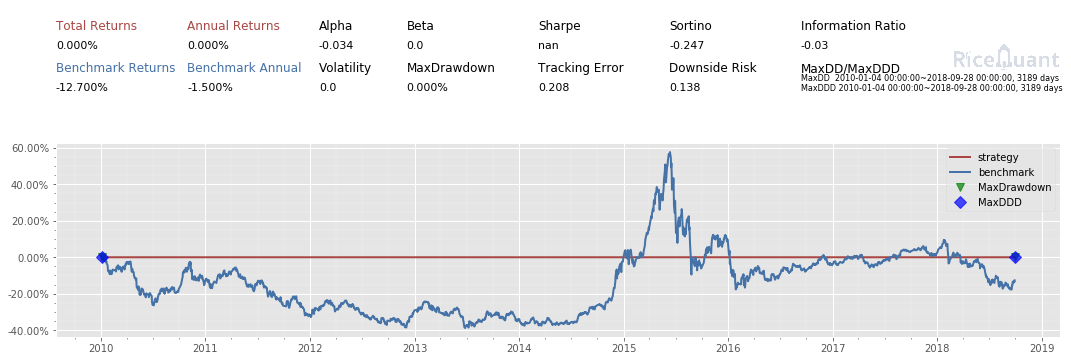

In [8]:
%%rqalpha -s 20100101 -e 20181001 -p -bm 000001.XSHG --account stock 100000
import numpy as np


# 在这个方法中编写任何的初始化逻辑。context对象将会在你的算法策略的任何方法之间做传递。
def init(context):
    context.s1 = 'AG1612'
    context.s2 = 'AU1612'

    # 设置全局计数器
    context.counter = 0

    # 设置滚动窗口
    context.window = 60

    # 设置对冲手数,通过研究历史数据进行价格序列回归得到该值
    context.ratio = 15

    context.up_cross_up_limit = False
    context.down_cross_down_limit = False

    # 设置入场临界值
    context.entry_score = 2

    # 初始化时订阅合约行情。订阅之后的合约行情会在handle_bar中进行更新
    subscribe([context.s1, context.s2])


# before_trading此函数会在每天交易开始前被调用，当天只会被调用一次
def before_trading(context):
    # 样例商品期货在回测区间内有夜盘交易,所以在每日开盘前将计数器清零
    context.counter = 0


# 你选择的期货数据更新将会触发此段逻辑，例如日线或分钟线更新
def handle_bar(context, bar_dict):

    # 获取当前一对合约的仓位情况。如尚未有仓位,则对应持仓量都为0
    position_a = context.portfolio.positions[context.s1]
    position_b = context.portfolio.positions[context.s2]

    context.counter += 1
    # 当累积满一定数量的bar数据时候,进行交易逻辑的判断
    if context.counter > context.window:

        # 获取当天历史分钟线价格队列
        price_array_a = history_bars(context.s1, context.window, '1m', 'close')
        price_array_b = history_bars(context.s2, context.window, '1m', 'close')

        # 计算价差序列、其标准差、均值、上限、下限
        spread_array = price_array_a - context.ratio * price_array_b
        std = np.std(spread_array)
        mean = np.mean(spread_array)
        up_limit = mean + context.entry_score * std
        down_limit = mean - context.entry_score * std

        # 获取当前bar对应合约的收盘价格并计算价差
        price_a = bar_dict[context.s1].close
        price_b = bar_dict[context.s2].close
        spread = price_a - context.ratio * price_b

        # 如果价差低于预先计算得到的下限,则为建仓信号,'买入'价差合约
        if spread <= down_limit and not context.down_cross_down_limit:
            # 可以通过logger打印日志
            logger.info('spread: {}, mean: {}, down_limit: {}'.format(spread, mean, down_limit))
            logger.info('创建买入价差中...')

            # 获取当前剩余的应建仓的数量
            qty_a = 1 - position_a.buy_quantity
            qty_b = context.ratio - position_b.sell_quantity

            # 由于存在成交不超过下一bar成交量25%的限制,所以可能要通过多次发单成交才能够成功建仓
            if qty_a > 0:
                buy_open(context.s1, qty_a)
            if qty_b > 0:
                sell_open(context.s2, qty_b)
            if qty_a == 0 and qty_b == 0:
                # 已成功建立价差的'多仓'
                context.down_cross_down_limit = True
                logger.info('买入价差仓位创建成功!')

        # 如果价差向上回归移动平均线,则为平仓信号
        if spread >= mean and context.down_cross_down_limit:
            logger.info('spread: {}, mean: {}, down_limit: {}'.format(spread, mean, down_limit))
            logger.info('对买入价差仓位进行平仓操作中...')

            # 由于存在成交不超过下一bar成交量25%的限制,所以可能要通过多次发单成交才能够成功建仓
            qty_a = position_a.buy_quantity
            qty_b = position_b.sell_quantity
            if qty_a > 0:
                sell_close(context.s1, qty_a)
            if qty_b > 0:
                buy_close(context.s2, qty_b)
            if qty_a == 0 and qty_b == 0:
                context.down_cross_down_limit = False
                logger.info('买入价差仓位平仓成功!')

        # 如果价差高于预先计算得到的上限,则为建仓信号,'卖出'价差合约
        if spread >= up_limit and not context.up_cross_up_limit:
            logger.info('spread: {}, mean: {}, up_limit: {}'.format(spread, mean, up_limit))
            logger.info('创建卖出价差中...')
            qty_a = 1 - position_a.sell_quantity
            qty_b = context.ratio - position_b.buy_quantity
            if qty_a > 0:
                sell_open(context.s1, qty_a)
            if qty_b > 0:
                buy_open(context.s2, qty_b)
            if qty_a == 0 and qty_b == 0:
                context.up_cross_up_limit = True
                logger.info('卖出价差仓位创建成功')

        # 如果价差向下回归移动平均线,则为平仓信号
        if spread < mean and context.up_cross_up_limit:
            logger.info('spread: {}, mean: {}, up_limit: {}'.format(spread, mean, up_limit))
            logger.info('对卖出价差仓位进行平仓操作中...')
            qty_a = position_a.sell_quantity
            qty_b = position_b.buy_quantity
            if qty_a > 0:
                buy_close(context.s1, qty_a)
            if qty_b > 0:
                sell_close(context.s2, qty_b)
            if qty_a == 0 and qty_b == 0:
                context.up_cross_up_limit = False
                logger.info('卖出价差仓位平仓成功!')